<img src="images/esgf.png" width=250 alt="ESGF logo"></img>
<img src="images/logos/rooki_logo.png" width=125 alt="Rooki logo"></img>
<img src="images/logos/cartopy_logo.png" width=250 alt="Cartopy logo"></img>

# Demo: Regridding and Plotting with Rooki and Cartopy 


---

## Overview
In this notebook, we demonstrate how to use Rooki to regrid CMIP model data and plot it in Cartopy for two examples:

1. Regrid two CMIP models onto the same grid 
1. Coarsen the output for one model

## Prerequisites

| Concepts | Importance | Notes |
| --- | --- | --- |
| [Intro to intake-esgf](https://projectpythia.org/esgf-cookbook/notebooks/intro-search.html) | Necessary | |
| [Intro to Cartopy](https://foundations.projectpythia.org/core/cartopy/cartopy.html) | Necessary |  |
| [Using Rooki to access CMIP6 data](https://projectpythia.org/esgf-cookbook/notebooks/rooki.html) | Helpful | Familiarity with rooki |
| [Understanding of NetCDF](https://foundations.projectpythia.org/core/data-formats/netcdf-cf.html) | Helpful | Familiarity with metadata structure |

- **Time to learn**: 15 minutes



---

## Imports


In [1]:
import os

import rooki.operators as ops
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import cartopy.crs as ccrs
import cartopy.feature as cfeature

from intake_esgf import ESGFCatalog
from rooki import rooki
from matplotlib.gridspec import GridSpec
from mpl_toolkits.axes_grid1.inset_locator import inset_axes


## Example 1: Regrid two CMIP6 models onto the same grid

In this example, we want to compare the historical precipitation output between two CMIP models, CESM2 and CanESM5. Here will will look at the annual mean precipitation for 2010. 

### Access the desired datasets using intake-esgf and rooki

The function and workflow to read in CMPI6 data using `intake-esgf` and `rooki` in the next few cells are adapted from [intake-esgf-with-rooki.ipynb](https://github.com/ProjectPythia/esgf-cookbook/blob/cf69015a464b68ee28cfdd4a27cee4e9d6ca2ca9/notebooks/use-intake-esgf-with-rooki.ipynb). Essentially, we use `intake-esgf` to find the dataset IDs we want and then subset and average them using `rooki`.

In [2]:
def separate_dataset_id(full_dataset):
    return full_dataset[0].split("|")[0]


In [3]:
cat = ESGFCatalog()
cat.search(
        activity_id='CMIP',
        experiment_id=["historical",],
        variable_id=["pr"],
        member_id='r1i1p1f1',
        grid_label='gn',
        table_id="Amon",
        source_id = [ "CESM2", "CanESM5"]
    )

dsets = [separate_dataset_id(dataset) for dataset in list(cat.df.id.values)]
dsets


   Searching indices:   0%|          |0/2 [       ?index/s]

['CMIP6.CMIP.CCCma.CanESM5.historical.r1i1p1f1.Amon.pr.gn.v20190429',
 'CMIP6.CMIP.NCAR.CESM2.historical.r1i1p1f1.Amon.pr.gn.v20190401']

Subset the data to get the precipitation variable for 2010 and then average by time:

In [4]:
dset_list = [[]]*len(dsets)

for i, dset_id in enumerate(dsets):
    wf = ops.AverageByTime(
        ops.Subset(
            ops.Input('pr', [dset_id]),
            time='2010/2010'
        )
    )

    resp = wf.orchestrate()

    # if it worked, add the dataset to our list
    if resp.ok:
        dset_list[i] = resp.datasets()[0]
        
    # if it failed, tell us why
    else:
        print(resp.status)


Print the dataset list to get an overview of the metadata structure:

In [5]:
print(dset_list)


[<xarray.Dataset> Size: 37kB
Dimensions:    (lat: 64, time: 1, bnds: 2, lon: 128)
Coordinates:
  * lat        (lat) float64 512B -87.86 -85.1 -82.31 ... 82.31 85.1 87.86
  * lon        (lon) float64 1kB 0.0 2.812 5.625 8.438 ... 351.6 354.4 357.2
  * time       (time) object 8B 2010-01-01 00:00:00
Dimensions without coordinates: bnds
Data variables:
    lat_bnds   (time, lat, bnds) float64 1kB ...
    lon_bnds   (time, lon, bnds) float64 2kB ...
    pr         (time, lat, lon) float32 33kB ...
    time_bnds  (time, bnds) object 16B ...
Attributes: (12/53)
    CCCma_model_hash:            3dedf95315d603326fde4f5340dc0519d80d10c0
    CCCma_parent_runid:          rc3-pictrl
    CCCma_pycmor_hash:           33c30511acc319a98240633965a04ca99c26427e
    CCCma_runid:                 rc3.1-his01
    Conventions:                 CF-1.7 CMIP-6.2
    YMDH_branch_time_in_child:   1850:01:01:00
    ...                          ...
    tracking_id:                 hdl:21.14100/363e1ebe-46e7-43dc-9fe

### Compare the precipitation data between models

First, let's quickly plot the 2010 annual mean precipitation for each model to see what we're working with. Since precipitation values vary greatly in magnitude, using a log-normalized colormap makes the data easier to visualize. 

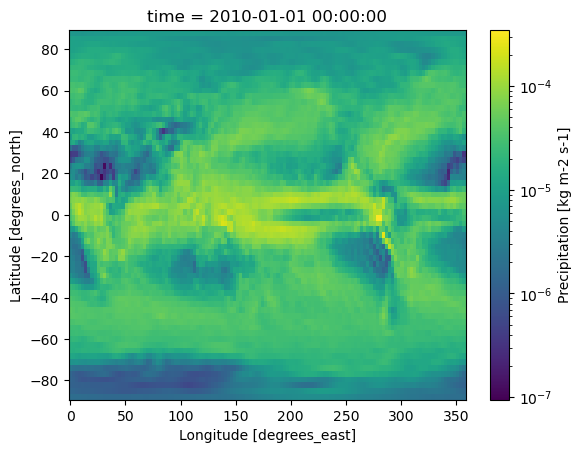

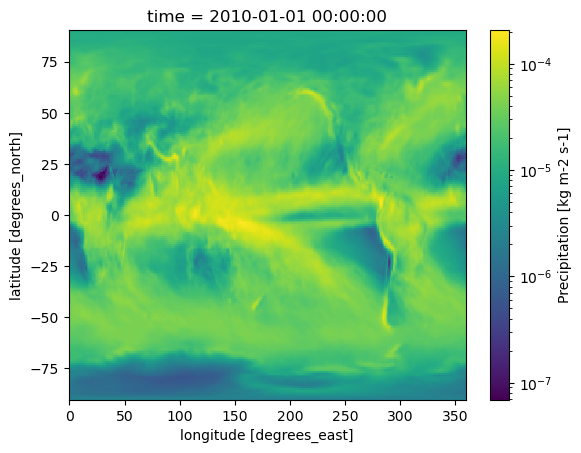

In [6]:
for dset in dset_list:
    dset.pr.plot(norm=mcolors.LogNorm())
    plt.show()

Uncomment and run the following cell. If we try to take the difference outright, it fails! 

In [7]:
# pr_diff = dset_list[0].pr - dset_list[1].pr

The models have different grids so we can't directly subtract the data. We can use the `grid` attribute to get information on which grid each uses.

In [8]:
print(dset_list[0].grid)
print(dset_list[1].grid)

T63L49 native atmosphere, T63 Linear Gaussian Grid; 128 x 64 longitude/latitude; 49 levels; top level 1 hPa
native 0.9x1.25 finite volume grid (192x288 latxlon)


### Regrid the models onto the same grid with Rooki

Look at the documentation on the `regrid` operator to see the available grid types and regrid methods:

In [9]:
rooki.regrid?

Signature: rooki.regrid(collection, method='nearest_s2d', grid='auto')
Docstring:
Run regridding operator on climate model data using daops (xarray).

Parameters
----------
collection : string
    A dataset identifier or list of comma separated identifiers. Example: c3s-cmip5.output1.ICHEC.EC-EARTH.historical.day.atmos.day.r1i1p1.tas.latest
method : {'nearest_s2d', 'bilinear', 'conservative', 'patch'}string
    Please specify regridding method like consevative or bilinear. Default: nearest_s2d
grid : {'auto', '0pt25deg', '0pt25deg_era5', '0pt5deg_lsm', '0pt625x0pt5deg', '0pt75deg', '1deg', '1pt25deg', '2pt5deg'}string
    Please specify output grid resolution for regridding. Default: auto

Returns
-------
output : ComplexData:mimetype:`application/metalink+xml; version=4.0`
    Metalink v4 document with references to NetCDF files.
prov : ComplexData:mimetype:`application/json`
    Provenance document using W3C standard.
prov_plot : ComplexData:mimetype:`image/png`
    Provenance docume

Here we'll do the same process as before to read in and subset the datasets with rooki, but now we **regrid using `ops.Regrid` before averaging over time**. In this example, we use `method=nearest_s2d` to regrid each model onto the target grid using a nearest neighbors method. The target grid is a 1.25° grid, specified by `grid='1pt25deg'`.


In [10]:
rg_list = [[]]*len(dsets)

for i, dset_id in enumerate(dsets):
    wf = ops.AverageByTime(
        ops.Regrid(
            ops.Subset(
                ops.Input('pr', [dset_id]),
                time='2010/2010'
            ),
            method='nearest_s2d',
            grid='1pt25deg'
        )
    )


    resp = wf.orchestrate()
    
    # if it worked, add the regridded dataset to our list
    if resp.ok:
        rg_list[i] = resp.datasets()[0]
        
    # if it failed, tell us why
    else:
        print(resp.status)
        

Print the list of regridded datasets to get an overview of the metadata structure. Note how `lat` and `lon` are now the same and each dataset has additional attributes, including `grid_original` and `regrid_operation`, which all keep track of the regridding operations we just completed.

In [11]:
print(rg_list)

[<xarray.Dataset> Size: 177kB
Dimensions:    (lat: 145, lon: 288, bnds: 2, time: 1)
Coordinates:
  * lat        (lat) float64 1kB -90.0 -88.75 -87.5 -86.25 ... 87.5 88.75 90.0
  * lon        (lon) float64 2kB 0.0 1.25 2.5 3.75 ... 355.0 356.2 357.5 358.8
    lat_bnds   (lat, bnds) float64 2kB ...
    lon_bnds   (lon, bnds) float64 5kB ...
  * time       (time) object 8B 2010-01-01 00:00:00
Dimensions without coordinates: bnds
Data variables:
    pr         (time, lat, lon) float32 167kB ...
    time_bnds  (time, bnds) object 16B ...
Attributes: (12/58)
    CCCma_model_hash:             3dedf95315d603326fde4f5340dc0519d80d10c0
    CCCma_parent_runid:           rc3-pictrl
    CCCma_pycmor_hash:            33c30511acc319a98240633965a04ca99c26427e
    CCCma_runid:                  rc3.1-his01
    Conventions:                  CF-1.7 CMIP-6.2
    YMDH_branch_time_in_child:    1850:01:01:00
    ...                           ...
    grid_original:                T63L49 native atmosphere, T63 

Now they are on the same grid!

In [12]:
print(rg_list[0].grid)
print(rg_list[1].grid)

Global 1.25 degree grid with one cell centered at 0E,0N. As used by ERA-40.
Global 1.25 degree grid with one cell centered at 0E,0N. As used by ERA-40.


### Quick plot the before and after for each model
The plots largely look the same, as they should - with the nearest neighbors method, we are just shifting the precipitation data onto a different grid without averaging between grid cells.

CanESM5


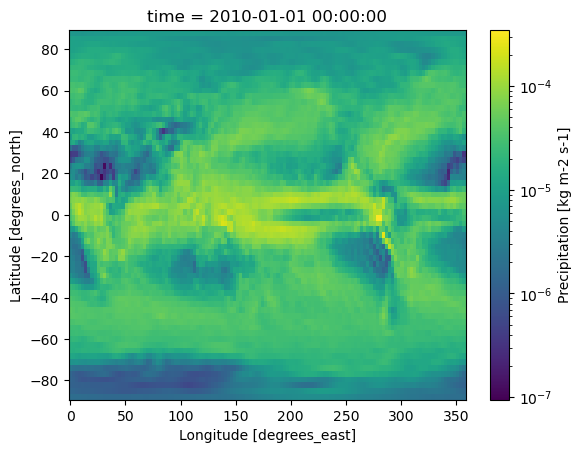

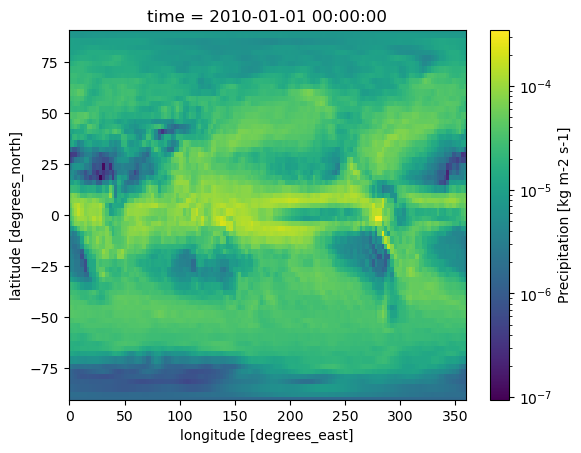

In [13]:
print(dset_list[0].source_id)
for ds in [dset_list[0], rg_list[0]]:
    ds.pr.plot(norm=mcolors.LogNorm())
    plt.show()


CESM2


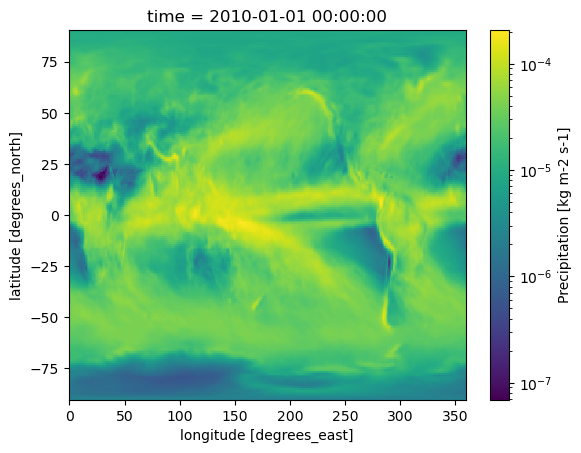

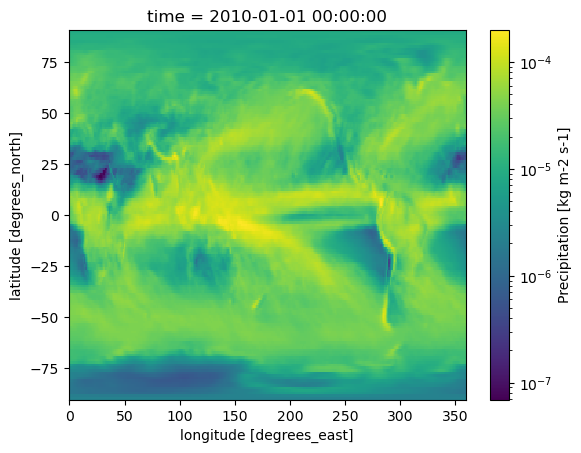

In [14]:
print(dset_list[1].source_id)
for ds in [dset_list[1], rg_list[1]]:
    ds.pr.plot(norm=mcolors.LogNorm())
    plt.show()


#### Take the difference between precipitation datasets and plot it
Now that both models are on the same grid, we can subtract the precipitation datasets and plot the difference!

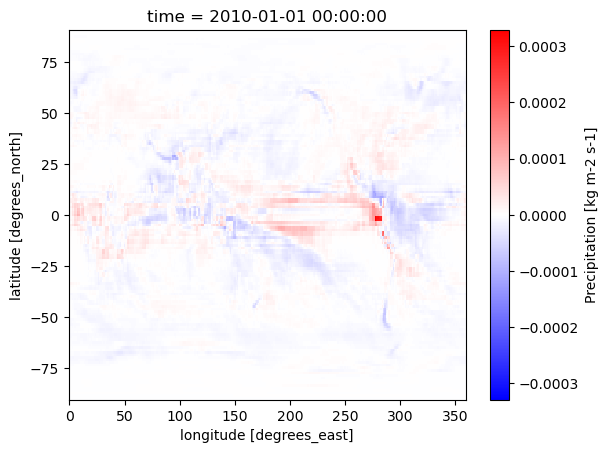

In [15]:
pr_diff = rg_list[0] - rg_list[1]

pr_diff.pr.plot(cmap="bwr")
plt.show()


### Plot everything together
Plot the regridded precipitation data as well as the difference between models on the same figure. We can use `Cartopy` to make it pretty. With `GridSpec`, we can also split up the figure and organize it to use the same colorbar for more than one panel.

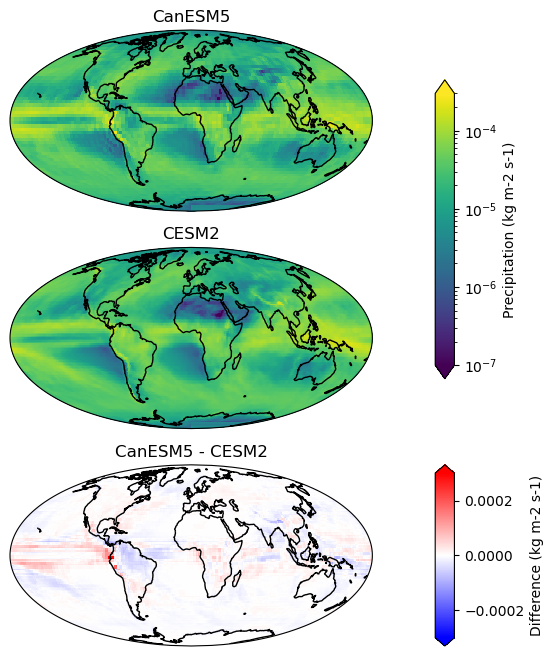

In [16]:
# set up figure
fig = plt.figure(figsize=(6, 8))
gs = GridSpec(3, 2, width_ratios=[1, 0.1], hspace=0.2)

# specify the projection
proj = ccrs.Mollweide()

# set up plots for each model
axpr_1 = plt.subplot(gs[0, 0], projection=proj)
axpr_2 = plt.subplot(gs[1, 0], projection=proj)
axdiff = plt.subplot(gs[2, 0], projection=proj)

# axes where the colorbar will go 
axcb_pr = plt.subplot(gs[:2, 1]) 
axcb_diff = plt.subplot(gs[2, 1])
axcb_pr.axis("off")
axcb_diff.axis("off")

# plot the precipitation for both models
for i, ax in enumerate([axpr_1, axpr_2]):
    ds_rg = rg_list[i]
    pcm = ax.pcolormesh(ds_rg.lon, ds_rg.lat, ds_rg.pr.isel(time=0), norm=mcolors.LogNorm(vmin=1e-7, vmax=3e-4),
                         transform=ccrs.PlateCarree()
                       )
    ax.set_title(ds_rg.parent_source_id)
    ax.add_feature(cfeature.COASTLINE)
    
# now plot the difference
pcmd = axdiff.pcolormesh(pr_diff.lon, pr_diff.lat, pr_diff.pr.isel(time=0), cmap="bwr", vmin=-3e-4, vmax=3e-4,
                         transform=ccrs.PlateCarree()
                        )
axdiff.set_title("{a} - {b}".format(a=rg_list[0].parent_source_id, b=rg_list[1].parent_source_id))
axdiff.add_feature(cfeature.COASTLINE)

# set the precipitation colorbar
axcb_pr_ins = inset_axes(axcb_pr, width="50%", height="75%", loc="center")
cbar_pr = plt.colorbar(pcm, cax=axcb_pr_ins, orientation="vertical", extend="both")
cbar_pr.set_label("{n} ({u})".format(n=rg_list[0].pr.long_name, u=rg_list[0].pr.units))

# set the difference colorbar
axcb_diff_ins = inset_axes(axcb_diff, width="50%", height="100%", loc="center")
cbar_diff = plt.colorbar(pcmd, cax=axcb_diff_ins, orientation="vertical", extend="both")
cbar_diff.set_label("Difference ({u})".format(u=pr_diff.pr.units))

plt.show()


## Example 2: Coarsen the output for one model

We can also use `Rooki` to regrid the data from one model onto a coarser grid. In this case, it may make more sense to use a conservative regridding method, which will conserve the physical fluxes between grid cells, rather than the nearest neighbors method we used in Example 1. 

### Get the data using intake-esgf and Rooki again

In this example, we'll look at the annual mean near-surface air temperature for CESM2 in 2010. 

In [17]:
cat = ESGFCatalog()
cat.search(
        activity_id='CMIP',
        experiment_id=["historical",],
        variable_id=["tas"],
        member_id='r1i1p1f1',
        grid_label='gn',
        table_id="Amon",
        source_id = [ "CESM2"]
    )

dsets = [separate_dataset_id(dataset) for dataset in list(cat.df.id.values)]
dsets


   Searching indices:   0%|          |0/2 [       ?index/s]

['CMIP6.CMIP.NCAR.CESM2.historical.r1i1p1f1.Amon.tas.gn.v20190308']

First, get the dataset with the original grid:

In [18]:
wf = ops.AverageByTime(
    ops.Subset(
        ops.Input('tas', [dsets[0]]),
        time='2010/2010'
    )
)

resp = wf.orchestrate()

if resp.ok:
    ds_og = resp.datasets()[0]
else:
    print(resp.status)


Use the `.grid` attribute to get information on the native grid:

In [19]:
ds_og.grid

'native 0.9x1.25 finite volume grid (192x288 latxlon)'

The native grid is 0.9°x1.25°, so let's try coarsening to a 1.25°x1.25° grid using the conservative method:

In [20]:
wf = ops.AverageByTime(
    ops.Regrid(
        ops.Subset(
            ops.Input('tas', [dsets[0]]),
            time='2010/2010'
        ),
        method='conservative',
        grid='1pt25deg'
    )
)

resp = wf.orchestrate()

if resp.ok:
    ds_125 = resp.datasets()[0]
else:
    print(resp.status)
    

In [21]:
ds_125.grid

'Global 1.25 degree grid with one cell centered at 0E,0N. As used by ERA-40.'

We can also make it even coarser by regridding to a 2.5°x2.5° grid:

In [22]:
wf = ops.AverageByTime(
    ops.Regrid(
        ops.Subset(
            ops.Input('tas', [dsets[0]]),
            time='2010/2010'
        ),
        method='conservative',
        grid='2pt5deg'
    )
)

resp = wf.orchestrate()

if resp.ok:
    ds_25 = resp.datasets()[0]
else:
    print(resp.status)
    

In [23]:
ds_25.grid

'Global 2.5 degree grid with one cell centered at 1.25E,1.25N.'

### Plot each dataset to look at the coarsened grids

Make a quick plot first:

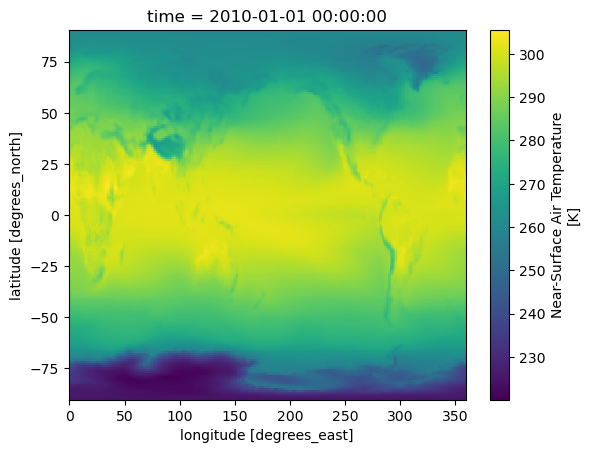

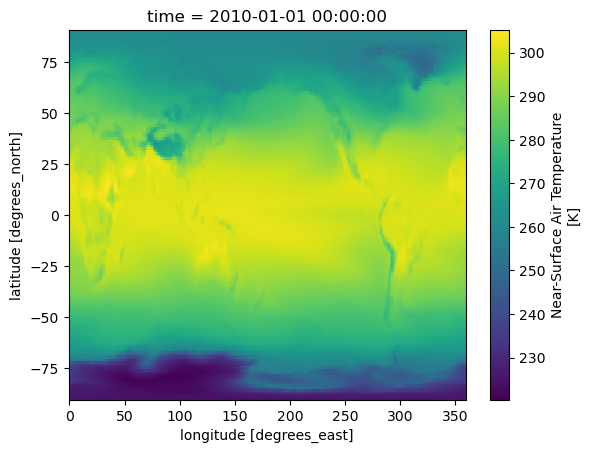

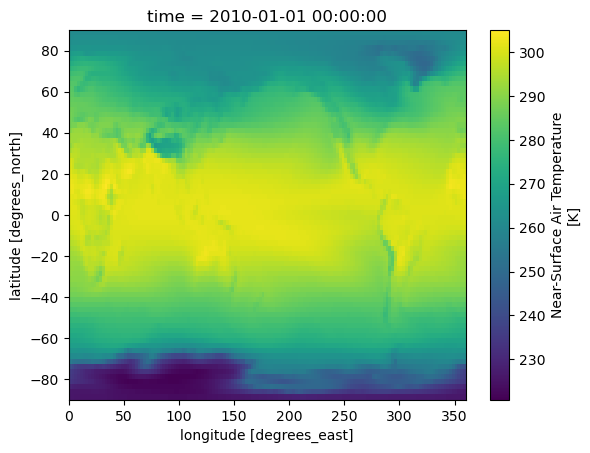

In [24]:
for ds in [ds_og, ds_125, ds_25]:
    ds["tas"].plot()
    plt.show()
    

### Plot the coarsened datsets together using Cartopy

Now let's zoom in on a smaller region, the continental US, to get a clear view of the difference in grid resolution. Here we can also decrease the colorbar limits to better see how the variable `tas` varies within the smaller region.

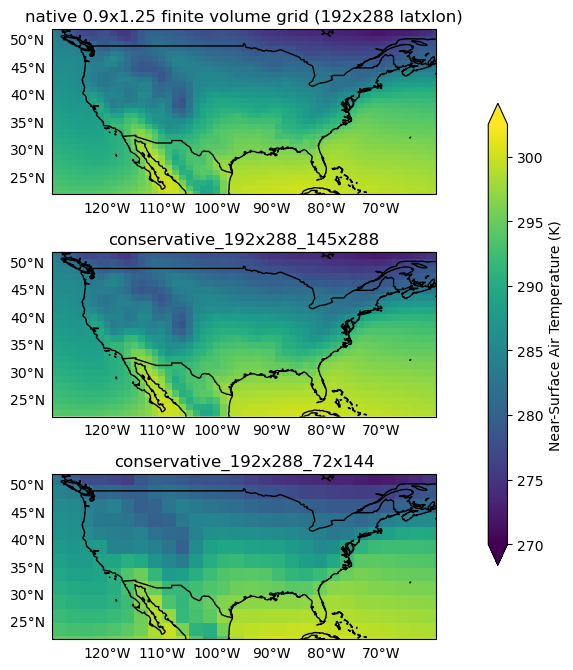

In [25]:
# set up the figure
fig = plt.figure(figsize=(6, 8))
gs = GridSpec(3, 2, width_ratios=[1, 0.1], height_ratios=[1, 1, 1], hspace=0.3, wspace=0.2)

# specify the projection
proj = ccrs.PlateCarree()

# set up plot axes
ax1 = plt.subplot(gs[0, 0], projection=proj)
ax2 = plt.subplot(gs[1, 0], projection=proj)
ax3 = plt.subplot(gs[2, 0], projection=proj)
axes_list = [ax1, ax2, ax3]

# set up colorbar axis
axcb = plt.subplot(gs[:, 1])

# loop through each dataset and its corresponding axis
for i, dset in enumerate([ds_og, ds_125, ds_25]):
    plot_ds = dset.tas.isel(time=0)
    ax = axes_list[i]
    pcm = ax.pcolormesh(plot_ds.lon, plot_ds.lat, plot_ds, vmin=270, vmax=302.5, transform=proj)
    
    # add borders and coastlines
    ax.add_feature(cfeature.BORDERS)
    ax.coastlines()
    
    # limit to CONUS for this example
    ax.set_xlim(-130, -60)
    ax.set_ylim(22, 52)
    
    # add grid labels on bottom & left only
    gl = ax.gridlines(color="None", draw_labels=True)
    gl.top_labels = False
    gl.right_labels = False
    
    # label with the regrid type; if it fails, that means it hasn't been regridded
    # (so label with the grid attribute instead)
    try:
        ax.set_title(dset.regrid_operation)
    except:
        ax.set_title(dset.grid)
        
# use the same colorbar for all plots
axcb.axis("off")
axcb_ins = inset_axes(axcb, width="50%", height="75%", loc="center")
cbar = plt.colorbar(pcm, cax=axcb_ins, orientation="vertical", extend="both")
cbar.set_label("{n} ({u})".format(n=plot_ds.long_name, u=plot_ds.units))
        
plt.show()


---

## Summary

`Rooki` offers a quick and easy way to regrid CMIP model data that can be located using `intake-esgf`. `Cartopy` lets us easily customize the plot to neatly display the geospatial data. 

## Resources and references
* [Regridding overview from NCAR](https://climatedataguide.ucar.edu/climate-tools/regridding-overview), including descriptions of various regridding methods
* [Rooki regridding example notebook](https://github.com/roocs/rooki/blob/master/notebooks/demo/demo-rooki-regrid-cmip6.ipynb)
* [Rooki documentation](https://rooki.readthedocs.io/en/latest/)
* [Cartopy logo image source](https://scitools.org.uk/cartopy/docs/v0.16/gallery/logo.html)
* [Rooki logo image source](https://rooki.readthedocs.io/en/latest/#)